In [32]:
mydict = {'Waste':"#009900", 'Nuclear':"#ffff00", 'Lignite':"#cc9900", 'Hard Coal':"#000000", 'Combined Cycle Gas':"#ffcc00", 'Gas':"#ffcc00", 'Oil':"#C43C1F",
 'Special':"#EA5EF0" }

In [ ]:

C = .map(mydict) #convert the list to a pandas series temporarily before mapping
D = list(C) # we transform the mapped values (a series object) back to a list
# entries in D = [1,2,1,3,4]

In [19]:
# unit commitment

# THIS IS THE MAIN CODE, IGNORE OTHERS

import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns
Conventionalcolor = "999999"
Nuclearcolor = "#ffff00"
Renewablescolor = "#009900"
Gascolor = "#ffcc00"
Nuclearcolor = "#ffff00"
Lignitecolor = "#cc9900"
Coalcolor = "#000000"
Othercolor = "#6600ff"
Oilcolor = ""

In [20]:
# Installed capacity MW
Prices2019 = pd.read_excel("Ewi/installed-capacity-2019.xlsx", sheet_name="prices", usecols="A:J", index_col="Prices")

Plants = pd.read_excel("Ewi/installed-capacity-2019.xlsx", sheet_name="Plants", usecols="S,V:AB")
DayAheadprices = pd.read_excel("smard/Day-ahead_prices_201901010000_201912312359.xlsx", sheet_name="Day-ahead prices", usecols="C:D", nrows=8761, parse_dates=["Datetime"])
DayAheadprices.set_index(['Datetime'], drop=False)
DayAheadprices.index = pd.to_datetime(DayAheadprices.Datetime, infer_datetime_format=True)
#print(DayAheadprices.info())
# Generation MWh
generation= pd.read_excel("smard/Actual_generation_201901010000_201912312359.xlsx", sheet_name="clean",   parse_dates=['Datetime'])
generation.set_index(['Datetime'], drop=False)
generation.index = pd.to_datetime(generation.Datetime, infer_datetime_format=True)
hourly_consumption = generation.Consumption
#print(generation.info())

In [51]:
#print(len(Grenzkosten))
#print(len(Plants))

#print(Grenzkosten)
#print(Prices2019.Nuclear.fuel)
print(Plants.head())
print(Plants.Technology.unique())
print(Plants.fuel.unique())

   Effizienz  Capacity  FuelCosts  variable  CumulativeCapacity   fuel  \
0       0.33     30.60        0.0       1.0               30.60  Waste   
1       0.33     29.75        0.0       1.0               60.35  Waste   
2       0.33     28.90        0.0       1.0               89.25  Waste   
3       0.33     10.20        0.0       1.0               99.45  Waste   
4       0.33     28.05        0.0       1.0              127.50  Waste   

  Technology  Grenzkosten  
0      Waste          1.0  
1      Waste          1.0  
2      Waste          1.0  
3      Waste          1.0  
4      Waste          1.0  
['Waste' 'Nuclear' 'Lignite' 'Hard Coal' 'Combined Cycle Gas' 'Gas' 'Oil'
 'Special']
['Waste' 'Nuclear' 'Lignite' 'Hard Coal' 'Natural Gas' 'Oil' 'Special']


In [10]:

Grenzkosten = [None] * len(Plants)
CO2price = 16
for i in range(len(Plants)):
    if Plants.fuel[i] == "Waste":
        Grenzkosten[i] =  Plants.FuelCosts[i]/Plants.Effizienz[i] + \
                            CO2price*Prices2019.Waste.emissions/Plants.Effizienz[i] + \
                            Plants.variable[i]
    elif Plants.fuel[i] == "Natural Gas":
        Grenzkosten[i] =  Plants.FuelCosts[i]/Plants.Effizienz[i] + \
                        CO2price*Prices2019.Gas.emissions/Plants.Effizienz[i] + \
                        Plants.variable[i]
    elif Plants.fuel[i] == "Oil":
        Grenzkosten[i] =  Plants.FuelCosts[i]/Plants.Effizienz[i] + \
                        CO2price*Prices2019.Oil.emissions/Plants.Effizienz[i] + \
                        Plants.variable[i]
    elif Plants.fuel[i] == "Special":
        Grenzkosten[i] =  Plants.FuelCosts[i]/Plants.Effizienz[i] + \
                        CO2price*Prices2019.Special.emissions/Plants.Effizienz[i] + \
                        Plants.variable[i]
    elif Plants.fuel[i] == "Lignite":
        Grenzkosten[i] =  Plants.FuelCosts[i]/Plants.Effizienz[i] + \
                        CO2price*Prices2019.Lignite.emissions/Plants.Effizienz[i] + \
                        Plants.variable[i]
    elif Plants.fuel[i] == "Hard Coal":
        Grenzkosten[i] =  Plants.FuelCosts[i]/Plants.Effizienz[i] + \
                        CO2price*Prices2019.HardCoal.emissions/Plants.Effizienz[i] + \
                        Plants.variable[i]
    elif Plants.fuel[i] == "Nuclear":
        Grenzkosten[i] =  Plants.FuelCosts[i]/Plants.Effizienz[i] + \
                        CO2price*Prices2019.Nuclear.emissions/Plants.Effizienz[i] + \
                        Plants.variable[i]
        
Plants['NEWGrenzkosten']  = Grenzkosten

In [5]:
AllREGeneration = generation.Biomass + generation.Hydropower + generation.WindOffshore + generation.WindOnshore +  generation.Photovoltaics + generation.OtherRE
AllConventional = generation.Nuclear + generation.BrownCoal + generation.HardCoal + generation.Gas + generation.OtherConventional 
TotalGeneration = AllREGeneration + AllConventional + generation.HydroPumpedStorage
NetExports = generation.exports + generation.imports 

NameError: name 'ResidualloadExports' is not defined

In [11]:
#-----------------------------------------------residual load
residual_load = hourly_consumption - AllREGeneration 
residual_load_Exports = hourly_consumption + NetExports - AllREGeneration
residual_load3RE = hourly_consumption - AllREGeneration*3

Residualload = residual_load.values
ResidualloadExports = residual_load_Exports.values
loadcurve = hourly_consumption.sort_values()[::-1]

residualcurve = residual_load.sort_values()[::-1]
residualcurve_Exports = residual_load_Exports.sort_values()[::-1]
residualcurve3RE = residual_load3RE.sort_values()[::-1]

In [57]:
#----------------------------------------------- DISPATCH Algorithm
Marginalcost =[]
technologyExports = []
CapacityExports =[]
# for num, load_H in enumerate(Residualload, start=1):
for num, load_H in enumerate(Residualload):  
    result_index =  (load_H - Plants.CumulativeCapacity).lt(0).idxmax()
    Marginalcost.append(Plants.Grenzkosten[result_index])
# Residual load with exports
MarginalcostExports =[]
for num, load_H in enumerate(ResidualloadExports):  
    result_index =  (load_H - Plants.CumulativeCapacity).lt(0).idxmax()
    MarginalcostExports.append(Plants.Grenzkosten[result_index])
    technologyExports.append(Plants.Technology[result_index])
    CapacityExports.append(Plants.Capacity[result_index])

In [13]:
# --------------------------------------------- Calculcated CO2 price
MarginalcostNEWCO2 =[]
PlantsCO2sorted = Plants.sort_values(by=['Grenzkosten'])
PlantsCO2sorted.CumulativeCapacity = Plants.Capacity.cumsum()
for num, load_H in enumerate(ResidualloadExports, start=1):
    result_index =  (load_H - PlantsCO2sorted.CumulativeCapacity).lt(0).idxmax()
    MarginalcostNEWCO2.append(PlantsCO2sorted.NEWGrenzkosten[result_index])

In [14]:
#no nuclear
PlantsNoNuclearindex  = Plants['fuel'] != "Nuclear"
PlantsNoNuclear  = Plants[PlantsNoNuclearindex]

MarginalcostNONUCLEAR =[]
for num, load_H in enumerate(Residualload, start=1):  
    result_index =  (load_H - PlantsNoNuclear.CumulativeCapacity).lt(0).idxmax()
    MarginalcostNONUCLEAR.append(PlantsNoNuclear.Grenzkosten[result_index])  

In [16]:
plantincome = [0] * len(Plants)
hoursactive = [0] * len(Plants)
# for every hour
for num, elec_price in enumerate(MarginalcostExports, start=0):
    # for every plant
    for plantnum, plantcost in enumerate(Plants.Grenzkosten[0:3], start=0):
        #print(elec_price, "- ", plantcost)
        if (plantcost <  elec_price): 
            plantincome[plantnum] += elec_price
            hoursactive[plantnum] += 1

#print(Plants.Grenzkosten[0:3])
#print(MarginalcostExports[0:10])

In [17]:
#no coal
PlantsNoCoalindex = Plants['fuel'] != "Hard Coal"
PlantsNoCoalNoLigniteindex = Plants['fuel'] != "Lignite"
PlantsNoCoalNoLigniteNonuclear = Plants[PlantsNoNuclearindex & PlantsNoCoalNoLigniteindex & PlantsNoCoalindex] 

MCNoCoalNoLigniteNonuclear =[]
for num, load_H in enumerate(Residualload, start=1):  
    result_index =  (load_H - PlantsNoCoalNoLigniteNonuclear.CumulativeCapacity).lt(0).idxmax()
    MCNoCoalNoLigniteNonuclear.append(PlantsNoCoalNoLigniteNonuclear.Grenzkosten[result_index])    

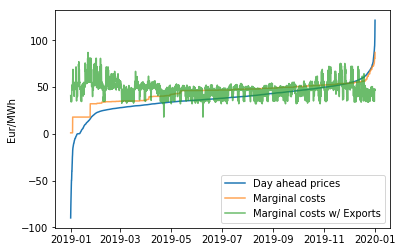

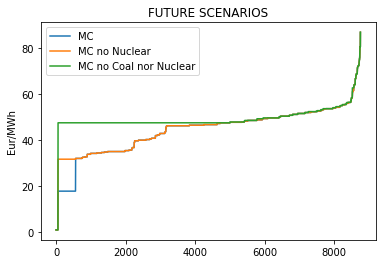

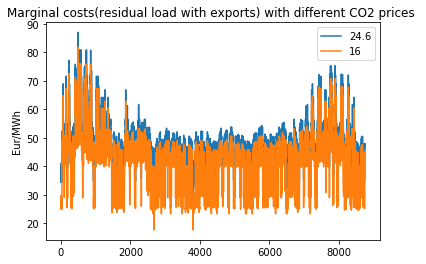

In [26]:
#-----------------------------------------------------------------------------------------------------------------------------
# GRAPHS
#-----------------------------------------------Electricity prics
plt.plot(DayAheadprices.index.values, DayAheadprices.Prices)
plt.plot(DayAheadprices.index.values, Marginalcost, alpha=0.7)
plt.plot(DayAheadprices.index.values, MarginalcostExports, alpha=0.7)
plt.legend([ "Day ahead prices",  "Marginal costs","Marginal costs w/ Exports"])
plt.ylabel('Eur/MWh') 
plt.show()   

plt.plot(Marginalcost)
plt.plot(MarginalcostNONUCLEAR)
plt.plot(MCNoCoalNoLigniteNonuclear)
plt.legend(['MC', "MC no Nuclear", "MC no Coal nor Nuclear"])
plt.title("FUTURE SCENARIOS")
plt.ylabel('Eur/MWh') 
plt.show() 

plt.plot(MarginalcostExports)
plt.plot(MarginalcostNEWCO2)

plt.legend(['24.6', CO2price])
plt.title("Marginal costs(residual load with exports) with different CO2 prices ")
plt.ylabel('Eur/MWh') 
plt.show() 

In [14]:
#-----------------------------------------------Electricity prics SORTED

In [58]:
C = (pd.Series(technologyExports)).map(mydict) 
techcolors = list(C)

labels = list(mydict.keys())
handles = [plt.Rectangle((0,0),1,1, color=mydict[label]) for label in labels]

MarginalcostExportssorted, tech_colorssorted, CapacityExportssorted = zip(*sorted(zip(MarginalcostExports, techcolors, CapacityExports)))
cummulativeCap = np.cumsum(CapacityExportssorted ) 

print(MarginalcostExportssorted[1:10])
print(techcolors[1:10])
print(CapacityExportssorted[1:100])
print(cummulativeCap[1:100])

(17.866666666666664, 17.866666666666664, 17.866666666666664, 17.866666666666664, 32.106716417910455, 32.106716417910455, 32.106716417910455, 32.106716417910455, 32.106716417910455)
['#cc9900', '#cc9900', '#cc9900', '#cc9900', '#cc9900', '#cc9900', '#cc9900', '#cc9900', '#cc9900']
(1247.78, 1247.78, 1247.78, 1247.78, 556.8, 556.8, 556.8, 556.8, 556.8, 556.8, 556.8, 556.8, 556.8, 556.8, 556.8, 556.8, 556.8, 556.8, 556.8, 556.8, 556.8, 556.8, 556.8, 556.8, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 922.2, 65.511, 65.511, 65.511, 65.511, 78.996, 78.996, 78.996, 563.76, 563.76, 563.76, 563.76, 563.76, 563.76, 563.76, 563.76, 563.76, 563.76, 563.76, 563.76, 563.76, 563.76, 546.36, 546.36, 546.36, 546.36, 546.36, 546.36, 546.36, 546.36, 546.36, 546.36, 546.36, 546.36, 546.36, 546.36, 546

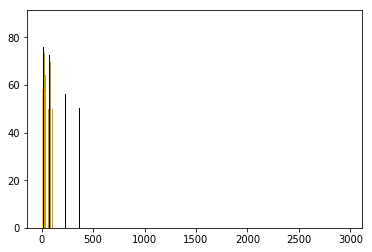

In [59]:

plt.bar(CapacityExportssorted,  MarginalcostExportssorted, color=techcolors)
#plt.legend(handles, labels)
plt.show()


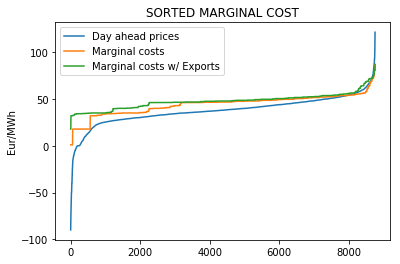

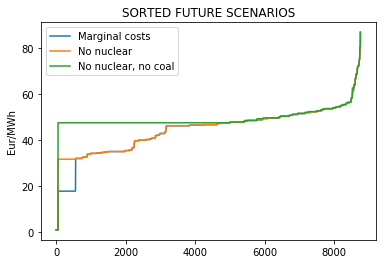

In [25]:
Dayahead = DayAheadprices.Prices.values
Dayahead.sort()
Marginalcost.sort()


MarginalcostNONUCLEAR.sort()
MCNoCoalNoLigniteNonuclear.sort()

plt.plot(Dayahead)
plt.plot(Marginalcost)
plt.plot(MarginalcostExportssorted)
plt.legend([ "Day ahead prices",   "Marginal costs","Marginal costs w/ Exports"])
plt.ylabel('Eur/MWh') 
plt.title("SORTED MARGINAL COST")
plt.show()

plt.plot(Marginalcost)
plt.plot(MarginalcostNONUCLEAR)
plt.plot(MCNoCoalNoLigniteNonuclear)
plt.legend(["Marginal costs","No nuclear", "No nuclear, no coal"])
plt.ylabel('Eur/MWh') 
plt.title("SORTED FUTURE SCENARIOS")
plt.show()

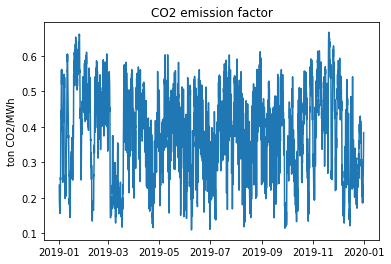

In [16]:
#Emissions
# MWh * tonCO2/ MWh = ton CO2
Emissions2019 = generation.Gas*Prices2019.Gas.emissions/Prices2019.Gas.efficiency \
                + generation.BrownCoal*Prices2019.Lignite.emissions/Prices2019.Lignite.efficiency\
                + generation.HardCoal*Prices2019.HardCoal.emissions /Prices2019.HardCoal.efficiency \
                + generation.OtherConventional*Prices2019.Special.emissions/Prices2019.HardCoal.efficiency
#CO2 emission factor ('ton CO2/MWh') 
CO2emissionfactor = Emissions2019/TotalGeneration


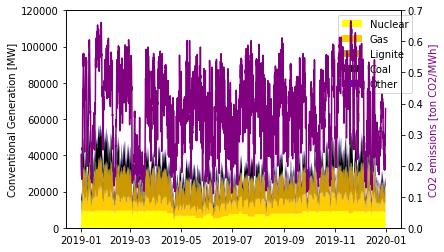

In [19]:
#----------------------------------------------- Generation graphs

fig, ax1 = plt.subplots()
pal = ( Nuclearcolor ,  Gascolor , Lignitecolor, Coalcolor, Othercolor)
labels = [ "Nuclear"   ,  "Gas"  , "Lignite" , "Coal" ,"Other" ]
ax1.stackplot(generation.index.values , generation.Nuclear  , generation.Gas ,\
              generation.BrownCoal , generation.HardCoal , generation.OtherConventional , colors=pal, labels=labels)

ax1.legend( bbox_to_anchor=(1.05, 1))
ax1.set_ylim( ymin=0, ymax=120000)
ax1.set_ylabel("Conventional Generation [MW]")
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot( CO2emissionfactor, color="purple" )
ax2.set_ylabel("CO2 emissions [ton CO2/MWh]", color="purple") 
ax2.set_ylim( ymin=0, ymax=0.7)

plt.show()

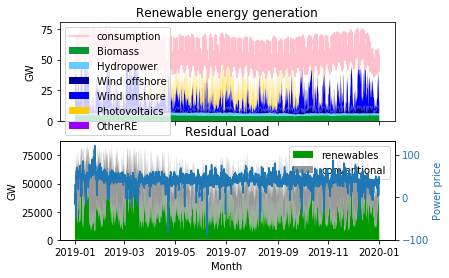

In [22]:
#Renewable energy generation'
labels = [ "Biomass", "Hydropower", "Wind offshore", "Wind onshore", "Photovoltaics" , "OtherRE" ]
pal = [ "#009933", "#66ccff",  "#000099", "#0000ff", "#ffcc00", "#9900ff" ]
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

ax1.plot( generation.index.values, hourly_consumption/1000  , color="pink", label="consumption")
ax1.stackplot(generation.index.values , generation.Biomass/1000 , generation.Hydropower/1000, generation.WindOffshore/1000, generation.WindOnshore/1000, generation.Photovoltaics/1000, generation.OtherRE/1000 ,   
labels=labels, colors =pal)
ax1.legend()

ax1.set_title('Renewable energy generation')
ax1.set_ylabel('GW') 


pal2 = [Renewablescolor, Conventionalcolor]
labels= ["renewables", "conventional"]
ax2.stackplot(generation.index.values , AllREGeneration,  AllConventional, colors=pal2,labels=labels)
ax3 = ax2.twinx()  
color = 'tab:blue'
ax3.set_ylabel('Power price', color=color) 
ax3.plot(generation.index.values, DayAheadprices.Prices,  color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax2.set_title('Residual Load')
ax2.legend()
#ax2.legend( bbox_to_anchor=(1.05, 1))
ax2.set_xlabel('Month')  
ax2.set_ylabel('GW') 
plt.show()

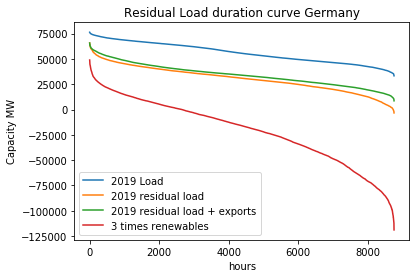

In [23]:
# -----------------------------------------------------------------------------------------------Residual Curves
plt.plot(loadcurve.values)
plt.plot(residualcurve.values)
plt.plot(residualcurve_Exports.values)
plt.plot(residualcurve3RE.values)

plt.xlabel("hours")
plt.ylabel("Capacity MW")
plt.title("Residual Load duration curve Germany")
plt.legend(["2019 Load", '2019 residual load', "2019 residual load + exports", "3 times renewables"])
plt.show()
